In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
import geopandas as gpd
from shapely.wkt import loads
from pyproj import Proj, Transformer

In [4]:

def lat_lon_to_axis(lat, lon, axis_direction=(1, 0), crs="EPSG:3857"):
    """
    Convert latitude and longitude to a one-dimensional value in meters along an axis.

    Args:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        axis_direction (tuple): Direction vector of the axis (x, y).
        crs (str): CRS for projecting to meters (default: EPSG:3857).

    Returns:
        float: One-dimensional projection value in meters.
    """
    
    # Define the transformer for projecting lat/lon to the desired CRS
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    
    # Project the latitude and longitude to meters
    x, y = transformer.transform(lon, lat)
    
    # Normalize the axis direction vector
    axis_vector = np.array(axis_direction)
    axis_unit_vector = axis_vector / np.linalg.norm(axis_vector)
    
    # Compute the projection of the point onto the axis
    projection_value = np.dot([x, y], axis_unit_vector)
    return projection_value

def find_traffic_light_id(row, segments_gdf):
    """
    Find the nearest segment ID to a given row in a DataFrame.

    Args:
        row (pd.Series): Row in a DataFrame with columns 'lat' and 'lon'.
        segments_gdf (gpd.GeoDataFrame): GeoDataFrame with segment geometries.

    Returns:
        int: ID of the nearest segment.
    """
    # Create a GeoDataFrame for the point
    point = gpd.GeoDataFrame(
        geometry=[loads(f"POINT ({row['lat']} {row['lon']})")], crs="EPSG:4326" # Make sure lat and lon is given completely right! Lat first then lon
    )
    
    # Reproject both point and segments to a projected CRS for accurate distance calculations
    projected_crs = "EPSG:4326"  # Common projected CRS for distance calculations
    point_proj = point.to_crs(projected_crs)
    segments_gdf_proj = segments_gdf.to_crs(projected_crs)
    max_distance = float("inf")
    nearest_segment_id = None
    for index, row in segments_gdf_proj.iterrows():
        distance = row.geometry.distance(point_proj.geometry[0])
        if distance < max_distance:
            max_distance = distance
            nearest_segment_id = index
    return nearest_segment_id


In [5]:
# loading the main dataframe
main_df = pd.read_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_traffic.csv")
# loading the traffic light states
with open("20181024_d1_0830_0900_traffic_light_states.json") as f:
    traffic_info = json.load(f)
# loading the segments
segments_gdf = gpd.read_file("20181024_d1_0830_0900_segments.csv")
# Convert to GeoDataFrame
if "geometry" in segments_gdf.columns:
    # Convert 'geometry' to shapely objects if needed
    segments_gdf["geometry"] = segments_gdf["geometry"].apply(loads)
    # Create GeoDataFrame and set the CRS to WGS 84 (latitude/longitude)
    segments_gdf = gpd.GeoDataFrame(segments_gdf, geometry="geometry", crs="EPSG:4326")
else:
    raise ValueError("The DataFrame does not have a 'geometry' column.")

# Reproject to a projected CRS (replace EPSG code with appropriate UTM zone)
segments_gdf = segments_gdf.to_crs("EPSG:25832")  # Example for UTM Zone 32N

# Calculate lengths
segments_gdf["length"] = segments_gdf.geometry.length
segments_gdf = segments_gdf.to_crs("EPSG:4326")  # Example for UTM Zone 32N

lon_one_axis_trajectory = []
lat_one_axis_trajectory = []
for i, row in segments_gdf.iterrows():
    lat_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[0][1], row.geometry.coords.xy[0][0], crs="EPSG:4326"))
    lon_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[1][1], row.geometry.coords.xy[1][0], crs="EPSG:4326"))

segments_gdf["lon_one_axis_trajectory"] = lon_one_axis_trajectory
segments_gdf["lat_one_axis_trajectory"] = lat_one_axis_trajectory

# Calculate total length
total_length = segments_gdf["length"].sum()

# loading the traffic lights
traffic_lights_df = pd.read_csv("traffic_lights.csv")
# find traffic light segment id
traffic_lights_df["nearest_segment_id"] = traffic_lights_df.apply(find_traffic_light_id, axis=1, segments_gdf=segments_gdf)
traffic_lights_df = traffic_lights_df.iloc[:5, :]
# loading the traffic light states
with open("traffic_info_dict.pkl", "rb") as f:
    traffic_lights_dict_states = pickle.load(f)

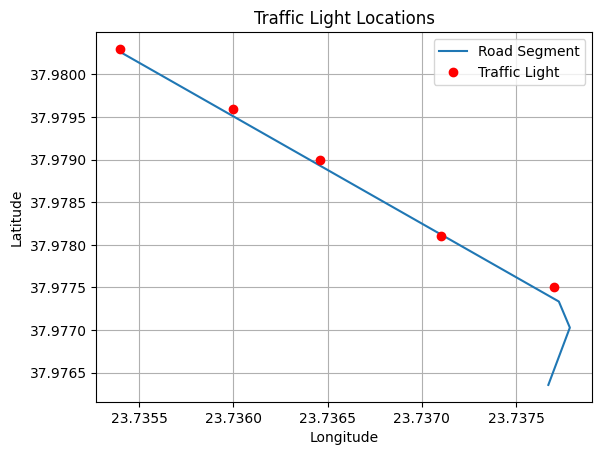

In [6]:
plt.plot(segments_gdf["lon_one_axis_trajectory"], segments_gdf["lat_one_axis_trajectory"], "-", label="Road Segment")
plt.plot(traffic_lights_df["lon"], traffic_lights_df["lat"], "ro", label="Traffic Light")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Traffic Light Locations")
plt.legend()
plt.ticklabel_format(useOffset=False)
plt.grid()
plt.show()

# Define the constants for truncating

In [7]:
DISTANCE_THRESHOLD = 5

# Normalize the one axis trajectory

In [9]:
from CTM_classic import CTMParameters, initialize_density, update_cell_status
from helper import veh_to_density
from sklearn.preprocessing import normalize

# Initialize CTM parameters
ctm_params = CTMParameters()
ctm_params.segment_length = segments_gdf["length"].mean()

# Truncate points that are too far from the main corridor line
main_df_truncated = main_df[main_df["temp_distance"] < DISTANCE_THRESHOLD].copy()  # Ensure it's a copy
# main_df_truncated["one_axis_trajectory"] = main_df_truncated.apply(lambda row: lat_lon_to_axis(row["lat"], row["lon"], crs="EPSG:4326"), axis=1)

# Normalize trajectory
normalized_trajectory = (
    main_df_truncated["one_axis_trajectory"] - main_df_truncated["one_axis_trajectory"].min()
)
normalized_trajectory = normalized_trajectory / normalized_trajectory.max() * segments_gdf["length"].sum()

# Assign to the DataFrame safely
main_df_truncated.loc[:, "normalized_trajectory"] = normalized_trajectory


In [10]:
main_df_truncated

,lat,lon,speed,lon_acc,lat_acc,time,dist_to_start,dist_to_end,veh_id,segment_id,temp_distance,one_axis_trajectory,closest_traffic_light,distance_to_traffic_light,normalized_trajectory
0,37.979949,23.735613,29.3152,-0.1790,-0.0253,0.00,9.254831,459.678657,32.0,1.0,3.190766,2.642236e+06,0,43.220861,63.437439
1,37.979946,23.735615,29.2910,-0.1578,-0.0291,0.04,9.586996,459.303356,32.0,1.0,3.224027,2.642237e+06,0,43.597100,63.916212
2,37.979944,23.735617,29.2684,-0.1552,-0.0329,0.08,9.857971,459.030760,32.0,1.0,3.188256,2.642237e+06,0,43.873348,64.394986
3,37.979941,23.735619,29.2469,-0.1446,-0.0366,0.12,10.194706,458.655467,32.0,1.0,3.221517,2.642237e+06,0,44.249611,64.873759
4,37.979939,23.735621,29.2288,-0.1061,-0.0403,0.16,10.467632,458.382890,32.0,1.0,3.185746,2.642237e+06,0,44.525965,65.352532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672406,37.980044,23.735572,28.9885,0.3464,0.7262,818.64,6.830528,470.813214,918.0,0.0,0.196335,2.642232e+06,0,32.183260,53.622590
672407,37.980041,23.735574,29.0103,0.3757,0.7476,818.68,6.678863,470.437966,918.0,0.0,0.229596,2.642232e+06,0,32.559763,54.101363
672408,37.980039,23.735576,29.0349,0.3894,0.7668,818.72,6.627068,470.165489,918.0,0.0,0.193825,2.642232e+06,0,32.838304,54.580136
672409,37.980036,23.735577,29.0621,0.4186,0.7833,818.76,6.446423,469.823714,918.0,0.0,0.314004,2.642232e+06,0,33.173530,54.819523


In [11]:
from shapely.geometry import LineString
# Initialize densities for each segment
segment_densities_predicted = {idx: initialize_density(ctm_params) for idx in segments_gdf.index}

def divide_linestring(linestring, n):
    """
    Divides a LINESTRING into n equal parts.

    :param linestring: A Shapely LineString object
    :param n: Number of equal parts to divide into
    :return: A list of LineString objects representing the segments
    """
    if not isinstance(linestring, LineString):
        raise ValueError("Input must be a Shapely LineString")

    # Get the total length of the LineString
    total_length = linestring.length

    # Calculate the step for division
    distances = np.linspace(0, total_length, n + 1)

    # Create parts
    parts = []
    for i in range(len(distances) - 1):
        start_point = linestring.interpolate(distances[i])
        end_point = linestring.interpolate(distances[i + 1])
        parts.append(LineString([start_point, end_point]))

    return gpd.GeoSeries(parts)

cells_linestring = []
for segment_id, segment in segments_gdf.iterrows():
    # Divide the segment into cells
    cells = divide_linestring(segment["geometry"], len(segment_densities_predicted[segment_id])) #‌ TODO check if the length of the cells is correct
    cells_linestring.append(cells)

# Flatten the cells into a new column for each segment
segments_gdf["cells_linestring"] = cells_linestring

# If you want to ensure individual cells are separate rows, you can explode the column
segments_gdf_exploded = segments_gdf.explode("cells_linestring").reset_index().rename(columns={"index": "segment_id"})

# Assuming `segments_gdf` is your DataFrame

# Group by `segment_id` and collect `cells_linestring` into lists
grouped = segments_gdf_exploded.groupby("segment_id")["cells_linestring"].apply(list).reset_index()

# Expand the lists into separate columns
expanded = pd.DataFrame(grouped["cells_linestring"].tolist(), index=grouped["segment_id"])

# Add the other columns you want to retain (e.g., `geometry`, `length`, etc.)
metadata = segments_gdf_exploded.drop_duplicates(subset="segment_id").set_index("segment_id")[["geometry", "length", "lon_one_axis_trajectory", "lat_one_axis_trajectory"]]
segments_gdf_exploded = metadata.join(expanded)

# Rename the columns for clarity (optional)
segments_gdf_exploded.columns = list(metadata.columns) + [f"cell_{i+1}" for i in range(expanded.shape[1])]

# Reset index for a clean DataFrame
segments_gdf_exploded = segments_gdf_exploded.reset_index()
for column in segments_gdf_exploded.columns:
    if column.startswith("cell_"):
        segments_gdf_exploded[column] = gpd.GeoSeries(segments_gdf_exploded[column])
segments_gdf_exploded.head(2)

NameError: name 'result' is not defined

# Find the closest cell

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm  # Import tqdm for progress

def find_closest_cell(lat, lon, segments_gdf_exploded):
    """
    Find the nearest segment ID to a given point.
    
    Args:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        segments_gdf_exploded (GeoDataFrame): GeoDataFrame with segment geometries and cell data.
    
    Returns:
        str: ID of the nearest cell (e.g., 'cell_1').
    """
    # Create a GeoDataFrame for the point
    point = gpd.GeoDataFrame(
        geometry=[Point(lat, lon)], crs="EPSG:4326"
    )

    # Reproject both point and segments to a projected CRS for accurate distance calculations
    projected_crs = "EPSG:3395"  # Consider using a projected CRS suitable for distance measurements
    point_proj = point.to_crs(projected_crs)

    max_distance = float("inf")
    nearest_cell_id = None

    # Iterate through the segments and calculate distances
    for index, row in segments_gdf_exploded.iterrows():
        cell_columns = row.filter(regex=r'^cell_\d')  # Use raw string to avoid escape sequence warning
        if not cell_columns.empty:
            for cell_id, cell_value in cell_columns.items():
                # Assuming the cell_value corresponds to a geometry, e.g., a LineString or Polygon
                cell_geometry = segments_gdf_exploded.at[index, cell_id]
                # Convert to GeoSeries and reproject
                if isinstance(cell_geometry, gpd.GeoSeries):
                    cell_geometry = cell_geometry.to_crs(projected_crs)
                else:
                    cell_geometry = gpd.GeoSeries([cell_geometry], crs=segments_gdf_exploded.crs).to_crs(projected_crs).iloc[0]
                if cell_geometry and cell_geometry.is_valid:  # Ensure the geometry is valid
                    # Calculate the distance from the point to the cell geometry
                    distance = point_proj.distance(cell_geometry)

                    # Check if distance is scalar (just in case it's returned as a Series)
                    if isinstance(distance, (float, int)):  # Ensure it's a scalar
                        if distance < max_distance:
                            max_distance = distance
                            nearest_cell_id = cell_id  # Capture the ID of the nearest cell
                    else:
                        # Handle the case where distance is a Series or other unexpected result
                        distance = distance.item()  # Convert to scalar if it's a Series
                        if distance < max_distance:
                            max_distance = distance
                            nearest_cell_id = cell_id

    return nearest_cell_id

# Adding a progress bar around the apply function
main_df_truncated_with_cell = main_df_truncated.copy()
# Wrap the apply function with tqdm for progress on each row
main_df_truncated_with_cell["closest_cell"] = [
    find_closest_cell(row["lat"], row["lon"], segments_gdf_exploded) 
    for _, row in tqdm(main_df_truncated_with_cell.iterrows(), total=len(main_df_truncated_with_cell), desc="Processing Rows")
]

print(f"The nearest cell IDs are: {main_df_truncated_with_cell['closest_cell']}")

main_df_truncated_with_cell.to_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_cell.csv")

Processing Rows: 100%|██████████| 1000/1000 [00:17<00:00, 56.21it/s]

The nearest cell IDs are: 14970    cell_3
14971    cell_4
14972    cell_4
14973    cell_4
14974    cell_4
          ...  
17293    cell_3
17294    cell_3
17295    cell_3
17296    cell_3
17297    cell_3
Name: closest_cell, Length: 1000, dtype: object


In [ ]:
from CTM_classic import update_cell_status

def simulate_corridor(segments_gdf, segment_densities_predicted, ctm_params, traffic_lights_df, traffic_lights_dict_states, total_time):
    # Initialize the inflow for the first segment
    entry_flow = 0  # Assuming no inflow at the start of the corridor

    # Simulate for a total time
    for t in np.arange(0, total_time, ctm_params.time_step):
        prev_outflow = entry_flow  # Outflow from the previous segment
        for segment_id in segments_gdf.index:
            # Get the current segment's density
            densities = segment_densities_predicted[segment_id]

            # Update densities for the segment
            new_densities = update_cell_status(
                t,
                segment_id,
                densities,
                ctm_params,
                prev_outflow,
                traffic_lights_df,
                traffic_lights_dict_states,
            )

            # Calculate the outflow from the last cell of the current segment
            last_cell_outflow = min(
                ctm_params.max_flow(),
                ctm_params.free_flow_speed * new_densities[-1] * ctm_params.time_step,
            )

            # Update the segment densities
            segment_densities_predicted[segment_id] = new_densities

            # Pass the outflow to the next segment
            prev_outflow = last_cell_outflow

        # Optionally: Store results or visualize densities at each time step
        print(f"Time {t}: {segment_densities_predicted}")

# Run the simulation
simulate_corridor(segments_gdf, segment_densities_predicted, ctm_params, traffic_lights_df, traffic_lights_dict_states, total_time=10)


Time 0.0: {0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 2: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 3: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 4: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 5: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 6: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 7: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 8: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 9: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 10: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 11: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 12: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 13: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 14: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
Time 0.04: {0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 2: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 3: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 4: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 5: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 6: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 7: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 8: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 9: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 10: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 11: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 12: [0.0, 0.0, 0.0, 0.0, 